# Assignment 1 - Investigating Transformer Models

Course: Deep Learning for NLP

This notebook is organized by the assignment rubric:
1. How models read text (BERT tokenizer)
2. Generating language (GPT)
3. BERT vs GPT behavior
4. Tokenizer/model mismatch
5. Summarization

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoTokenizer,
    pipeline,
    set_seed,
)

random.seed(42)
torch.manual_seed(42)

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

DEVICE = 0 if torch.cuda.is_available() else -1
print("CUDA available:", torch.cuda.is_available())

C:\Users\JT\Desktop\aidi-2001\Assignment 1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


## Part 1 - How Models Read Text (BERT tokenizer)

Goal: Investigate how sentence properties (capitalization, punctuation, numbers, rare words, length) affect tokenization.

In [2]:
bert_tok = AutoTokenizer.from_pretrained("bert-base-uncased")

sentences = [
    "Hello world!",
    "HELLO world!",
    "Hello, world!!!",
    "The number 1024 is important.",
    "Supercalifragilisticexpialidocious is uncommon.",
    "A very very very very very long sentence with repeated words.",
]

rows = []
for s in sentences:
    ids = bert_tok(s, add_special_tokens=True)["input_ids"]
    toks = bert_tok.convert_ids_to_tokens(ids)
    rows.append({
        "text": s,
        "char_len": len(s),
        "token_len": len(toks),
        "tokens": " ".join(toks),
    })

sentence_df = pd.DataFrame(rows)
sentence_df

,text,char_len,token_len,tokens
0,Hello world!,12,5,[CLS] hello world ! [SEP]
1,HELLO world!,12,5,[CLS] hello world ! [SEP]
2,"Hello, world!!!",15,8,"[CLS] hello , world ! ! ! [SEP]"
3,The number 1024 is important.,29,9,[CLS] the number 102 ##4 is important . [SEP]
4,Supercalifragilisticexpialidocious is uncommon.,47,16,[CLS] super ##cal ##if ##rag ##ilis ##tic ##ex...
5,A very very very very very long sentence with ...,61,14,[CLS] a very very very very very long sentence...


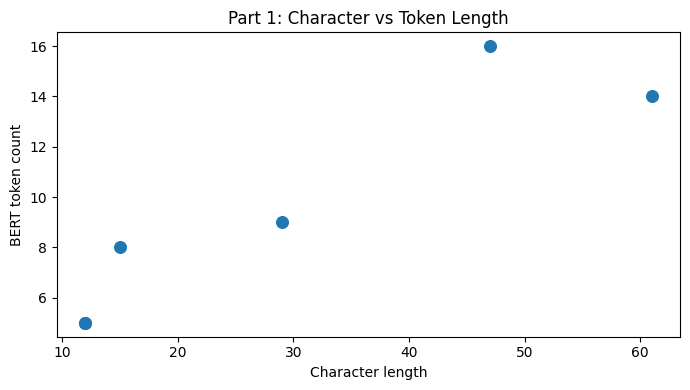

In [3]:
plt.figure(figsize=(7, 4))
plt.scatter(sentence_df["char_len"], sentence_df["token_len"], s=70)
plt.xlabel("Character length")
plt.ylabel("BERT token count")
plt.title("Part 1: Character vs Token Length")
plt.tight_layout()
plt.show()

sentence_df.to_csv(OUTPUT_DIR / "part1_sentence_tokenization.csv", index=False)

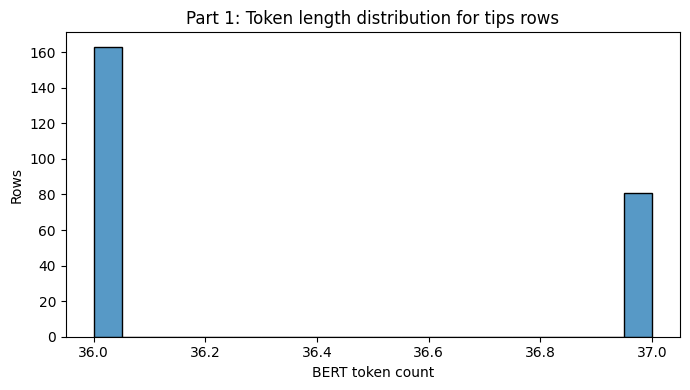

,description,char_len,token_len
0,Party size 2 paid total bill $16.99 with tip $...,96,36
1,Party size 3 paid total bill $10.34 with tip $...,94,36
2,Party size 3 paid total bill $21.01 with tip $...,94,36
3,Party size 2 paid total bill $23.68 with tip $...,94,36
4,Party size 4 paid total bill $24.59 with tip $...,96,36


In [4]:
tips = sns.load_dataset("tips").copy()

def row_to_text(r):
    return (
        f"Party size {int(r['size'])} paid total bill ${r['total_bill']:.2f} with tip ${r['tip']:.2f}. "
        f"Smoker={r['smoker']}, Day={r['day']}, Time={r['time']}, Sex={r['sex']}."
    )

tips["description"] = tips.apply(row_to_text, axis=1)
tips["char_len"] = tips["description"].str.len()
tips["token_len"] = tips["description"].apply(lambda x: len(bert_tok(x)["input_ids"]))

plt.figure(figsize=(7, 4))
sns.histplot(tips["token_len"], bins=20)
plt.xlabel("BERT token count")
plt.ylabel("Rows")
plt.title("Part 1: Token length distribution for tips rows")
plt.tight_layout()
plt.show()

tips[["description", "char_len", "token_len"]].head()

### Part 1 observations
- Numbers and punctuation often split into separate tokens; long rare words split into subwords.
- Character length and token length are correlated but not identical.
- Token count varies because tokenizers encode frequent chunks efficiently and break unfamiliar strings into more pieces.

## Part 2 - Generating Language (GPT)

Goal: Compare stability vs creativity by changing decoding settings.

In [5]:
gpt_tok = AutoTokenizer.from_pretrained("distilgpt2")
gpt_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
gpt_model.eval()

if gpt_tok.pad_token_id is None:
    gpt_tok.pad_token = gpt_tok.eos_token

prompts = [
    "The capital of France is",
    "I opened the fridge and found",
    "The number 1024 is important because",
]

sample = tips.sample(1, random_state=7).iloc[0]
prompts.append(
    "Restaurant record: "
    f"bill ${sample.total_bill:.2f}, tip ${sample.tip:.2f}, day {sample.day}, "
    f"time {sample.time}, party size {int(sample.size)}."
)

def generate_many(prompt, runs, **kwargs):
    out = []
    for i in range(runs):
        set_seed(100 + i)
        ids = gpt_tok(prompt, return_tensors="pt").input_ids
        with torch.no_grad():
            gen = gpt_model.generate(ids, **kwargs)
        out.append(gpt_tok.decode(gen[0], skip_special_tokens=True))
    return out

greedy_cfg = dict(max_new_tokens=35, do_sample=False, pad_token_id=gpt_tok.eos_token_id)
creative_cfg = dict(max_new_tokens=35, do_sample=True, temperature=0.9, top_p=0.9, pad_token_id=gpt_tok.eos_token_id)

rows = []
for p in prompts:
    for i, text in enumerate(generate_many(p, 3, **greedy_cfg), start=1):
        rows.append({"prompt": p, "setting": "greedy", "run": i, "output": text})
    for i, text in enumerate(generate_many(p, 3, **creative_cfg), start=1):
        rows.append({"prompt": p, "setting": "creative", "run": i, "output": text})

gen_df = pd.DataFrame(rows)
gen_df.head(12)

Loading weights: 100%|███████████████████████████████████████████| 76/76 [00:00<00:00, 364.92it/s, Materializing param=transformer.wte.weight]
GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


,prompt,setting,run,output
0,The capital of France is,greedy,1,The capital of France is the capital of the Fr...
1,The capital of France is,greedy,2,The capital of France is the capital of the Fr...
2,The capital of France is,greedy,3,The capital of France is the capital of the Fr...
3,The capital of France is,creative,1,The capital of France is to be used to the pro...
4,The capital of France is,creative,2,The capital of France is still the biggest cit...
5,The capital of France is,creative,3,The capital of France is also the largest city...
6,I opened the fridge and found,greedy,1,I opened the fridge and found a few things I d...
7,I opened the fridge and found,greedy,2,I opened the fridge and found a few things I d...
8,I opened the fridge and found,greedy,3,I opened the fridge and found a few things I d...
9,I opened the fridge and found,creative,1,I opened the fridge and found a new fridge whi...


In [6]:
gen_df.to_csv(OUTPUT_DIR / "part2_gpt_generations.csv", index=False)

comparison = (
    gen_df.groupby(["prompt", "setting"])
    .size()
    .reset_index(name="n_outputs")
)
comparison

,prompt,setting,n_outputs
0,I opened the fridge and found,creative,3
1,I opened the fridge and found,greedy,3
2,"Restaurant record: bill $19.44, tip $3.00, day...",creative,3
3,"Restaurant record: bill $19.44, tip $3.00, day...",greedy,3
4,The capital of France is,creative,3
5,The capital of France is,greedy,3
6,The number 1024 is important because,creative,3
7,The number 1024 is important because,greedy,3


### Part 2 observations
- Greedy decoding is more stable and often repeats high-probability phrasing.
- Sampling (`temperature`, `top_p`) increases diversity and can introduce instability.
- Creativity is controlled mainly by decoding strategy and sampling parameters.

## Part 3 - When Models Refuse to Behave (BERT vs GPT)

Test sentence: `Deep learning models are very`

In [7]:
prompt = "Deep learning models are very"

ids = gpt_tok(prompt, return_tensors="pt").input_ids
with torch.no_grad():
    gpt_out = gpt_model.generate(
        ids,
        max_new_tokens=20,
        do_sample=True,
        temperature=0.8,
        top_p=0.9,
        pad_token_id=gpt_tok.eos_token_id,
    )

gpt_result = gpt_tok.decode(gpt_out[0], skip_special_tokens=True)

fill_mask = pipeline("fill-mask", model="bert-base-uncased", tokenizer="bert-base-uncased", device=DEVICE)
masked = "Deep learning models are very [MASK]."
bert_preds = fill_mask(masked, top_k=5)

compare_rows = [{
    "model": "GPT (distilgpt2)",
    "task": "continuation",
    "input": prompt,
    "result": gpt_result,
}]

for pred in bert_preds:
    compare_rows.append({
        "model": "BERT (bert-base-uncased)",
        "task": "fill-mask",
        "input": masked,
        "result": f"{pred['token_str'].strip()} (score={pred['score']:.4f})",
    })

compare_df = pd.DataFrame(compare_rows)
compare_df

Loading weights: 100%|█████████████████████████| 202/202 [00:00<00:00, 505.67it/s, Materializing param=cls.predictions.transform.dense.weight]
BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
----------------------------+------------+--+-
cls.seq_relationship.weight | UNEXPECTED |  | 
bert.pooler.dense.weight    | UNEXPECTED |  | 
bert.pooler.dense.bias      | UNEXPECTED |  | 
cls.seq_relationship.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


,model,task,input,result
0,GPT (distilgpt2),continuation,Deep learning models are very,Deep learning models are very good at modeling...
1,BERT (bert-base-uncased),fill-mask,Deep learning models are very [MASK].,simple (score=0.1230)
2,BERT (bert-base-uncased),fill-mask,Deep learning models are very [MASK].,popular (score=0.0897)
3,BERT (bert-base-uncased),fill-mask,Deep learning models are very [MASK].,common (score=0.0708)
4,BERT (bert-base-uncased),fill-mask,Deep learning models are very [MASK].,effective (score=0.0505)
5,BERT (bert-base-uncased),fill-mask,Deep learning models are very [MASK].,different (score=0.0387)


### Part 3 explanation
- GPT succeeds at continuation because it predicts the next token left-to-right.
- BERT fails at open-ended continuation because it is not trained as an autoregressive generator.
- BERT works differently by predicting a masked token using both left and right context.

## Part 3.5 - Can We Swap Their Brains? (Tokenizer vs Model)

In [8]:
mismatch_rows = []

# GPT model + BERT tokenizer
try:
    bert_tok2 = AutoTokenizer.from_pretrained("bert-base-uncased")
    gpt_model2 = AutoModelForCausalLM.from_pretrained("distilgpt2")
    ids = bert_tok2("The capital of France is", return_tensors="pt").input_ids
    with torch.no_grad():
        out = gpt_model2.generate(ids, max_new_tokens=12)
    mismatch_rows.append({
        "pair": "GPT model + BERT tokenizer",
        "status": "ran",
        "outcome": bert_tok2.decode(out[0], skip_special_tokens=True),
    })
except Exception as e:
    mismatch_rows.append({
        "pair": "GPT model + BERT tokenizer",
        "status": "error",
        "outcome": str(e),
    })

# BERT model + GPT tokenizer
try:
    gpt_tok2 = AutoTokenizer.from_pretrained("distilgpt2")
    bert_mlm = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
    ids = gpt_tok2("Deep learning models are very", return_tensors="pt").input_ids
    with torch.no_grad():
        logits = bert_mlm(ids).logits
    pred_id = int(torch.argmax(logits[0, -1]).item())
    mismatch_rows.append({
        "pair": "BERT model + GPT tokenizer",
        "status": "ran",
        "outcome": f"Predicted id {pred_id} decoded by GPT tokenizer as: {gpt_tok2.decode([pred_id])}",
    })
except Exception as e:
    mismatch_rows.append({
        "pair": "BERT model + GPT tokenizer",
        "status": "error",
        "outcome": str(e),
    })

mismatch_df = pd.DataFrame(mismatch_rows)
mismatch_df

Loading weights: 100%|███████████████████████████████████████████| 76/76 [00:00<00:00, 556.57it/s, Materializing param=transformer.wte.weight]
GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Loading weights: 100%|█████████████████████████| 202/202 [00:00<00:00, 420.79it/s, Materializing param=cls.predictions.transform.dense.weight]
BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
------------

,pair,status,outcome
0,GPT model + BERT tokenizer,ran,the capital of france is [unused193] [unused19...
1,BERT model + GPT tokenizer,ran,Predicted id 1000 decoded by GPT tokenizer as:...


### Final question answer
A pretrained model generally cannot be paired with a different tokenizer because token IDs are part of the model's learned representation. If token ID 1234 meant one subword during training but maps to a different token at inference time, the embedding lookup and all downstream layers receive semantically incorrect inputs, causing degraded or nonsensical behavior.

## Part 4 - Compressing Information (Summarization)

In [9]:
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=DEVICE)

natural_paragraph = (
    "Transformer models are used for classification, question answering, and generation. "
    "They perform strongly but can still hallucinate facts or repeat phrases under some decoding settings. "
    "Careful evaluation is needed before deployment in high-stakes use cases."
)

penguins = sns.load_dataset("penguins").dropna().head(8)
structured_text = " ".join([
    f"Penguin {i}: species {r.species}, island {r.island}, bill length {r.bill_length_mm:.1f} mm, "
    f"bill depth {r.bill_depth_mm:.1f} mm, flipper {r.flipper_length_mm:.1f} mm, mass {r.body_mass_g:.1f} g."
    for i, r in penguins.iterrows()
])

mixed_text = (
    "Field notes from a biology class: students measured penguins and discussed species differences. "
    + structured_text +
    " The instructor asked students to interpret size patterns across islands."
)

inputs = {
    "natural_paragraph": natural_paragraph,
    "structured_penguins": structured_text,
    "mixed_structured_natural": mixed_text,
}

sum_rows = []
for name, text in inputs.items():
    out = summarizer(text, max_length=75, min_length=20, do_sample=False)[0]["summary_text"]
    sum_rows.append({"input_name": name, "summary": out})

sum_df = pd.DataFrame(sum_rows)
sum_df

KeyError: "Unknown task summarization, available tasks are ['any-to-any', 'audio-classification', 'automatic-speech-recognition', 'depth-estimation', 'document-question-answering', 'feature-extraction', 'fill-mask', 'image-classification', 'image-feature-extraction', 'image-segmentation', 'image-text-to-text', 'image-to-image', 'keypoint-matching', 'mask-generation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'table-question-answering', 'text-classification', 'text-generation', 'text-to-audio', 'text-to-speech', 'token-classification', 'video-classification', 'visual-question-answering', 'vqa', 'zero-shot-audio-classification', 'zero-shot-classification', 'zero-shot-image-classification', 'zero-shot-object-detection', 'translation_XX_to_YY']"

### Part 4 observations
- One summary that works well: `natural_paragraph` usually preserves the main message.
- One summary that loses important information: `structured_penguins` often drops numeric detail.
- Consistent mistake: model compresses many measurements into vague language.
- Structured data is difficult because summarization models are mainly trained on narrative text, not dense tabular facts.

## Submission checklist
- Experiments included for all required parts.
- Tables/figures included for tokenization and generation comparison.
- Short explanations provided under each section.

Run all cells before submission and verify outputs are visible.